### 1. Imports

In [ ]:
import os
import csv
import random
from pathlib import Path
from typing import Tuple, List

import numpy as np
import pandas as pd
from PIL import Image

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split

from sklearn.metrics import roc_curve, auc, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import matplotlib.pyplot as plt
%matplotlib inline


### 2. Globals

In [ ]:
ROOT_DIR     = Path('.')
CSV_PATH     = ROOT_DIR/'data/images/0_data.csv'
MASK_DIR     = ROOT_DIR/'data/masked'          # contains IMG_xxxx_mask.jpg
SEED         = 42
BATCH_SIZE   = 64
LR           = 1e-3
EPOCHS       = 150
VAL_SPLIT    = 0.30                            # 80 / 20
DEVICE       = 'cuda' if torch.cuda.is_available() else 'cpu'

torch.manual_seed(SEED)
random.seed(SEED)
np.random.seed(SEED)


### 3. Utils

In [ ]:
# Colour codes on the active device (cuda or cpu)
WORM_RGB = torch.tensor([255,   0,   0], dtype=torch.uint8, device=DEVICE)   # red
LEAF_RGB = torch.tensor([  0, 255,   0], dtype=torch.uint8, device=DEVICE)   # green
BACK_RGB = torch.tensor([128, 128, 128], dtype=torch.uint8, device=DEVICE)   # gray

@torch.no_grad()
def class_pixel_counts(img: Image.Image) -> torch.Tensor:
    """
    Returns a 3-element CUDA/CPU tensor [worms, leaves, background] with pixel counts.
    Run on GPU if available
    """
    # PIL → writable NumPy → tensor on DEVICE
    arr = torch.from_numpy(np.asarray(img, dtype=np.uint8).copy()).to(DEVICE)   # H×W×3 uint8
    worms = torch.all(arr == WORM_RGB, dim=-1)
    leaves = torch.all(arr == LEAF_RGB, dim=-1)
    backs  = torch.all(arr == BACK_RGB, dim=-1)
    return torch.stack([worms.sum(), leaves.sum(), backs.sum()]).float()        # shape (3,)

def to_ratios(cnt: torch.Tensor) -> torch.Tensor:
    """
    Normalise the three counts so they sum to 1.0  ➜ tensor(shape=(3,))
    """
    return cnt / (cnt.sum() + 1e-6)

### 4. Data

In [ ]:
class SilkwormFeedDataset(Dataset):
    """
    Each sample (ratios[worm, leaf, back]  (device),  label (device))
    """
    def __init__(self, csv_file: Path, mask_dir: Path):
        df = pd.read_csv(csv_file, engine='python')
        feats, labels = [], []

        for _, row in df.iterrows():
            mask_path = mask_dir / f"{Path(row['foto']).stem}_mask.png"
            if not mask_path.exists():
                continue
            counts = class_pixel_counts(Image.open(mask_path))
            feats.append(to_ratios(counts))
            labels.append(float(row['classificazione']))

        self.x = torch.stack(feats).to(DEVICE)                  # [N, 3]
        self.y = torch.tensor(labels, dtype=torch.float32, device=DEVICE).unsqueeze(1) # [N, 1]

    def __len__(self):          
        return len(self.x)
    
    def __getitem__(self, idx): 
        return self.x[idx], self.y[idx]



# 35s to load dataset on 1660 Ti Mobile
full_ds = SilkwormFeedDataset(CSV_PATH, MASK_DIR)
train_sz = int(len(full_ds) * (1 - VAL_SPLIT))
val_sz   = len(full_ds) - train_sz
train_ds, val_ds = random_split(full_ds, [train_sz, val_sz], generator=torch.Generator().manual_seed(SEED))

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
val_loader   = DataLoader(val_ds,   batch_size=BATCH_SIZE, shuffle=False)

print(f"Dataset sizes ➜  Train: {len(train_ds)}   Val: {len(val_ds)}")


Dataset sizes ➜  Train: 945   Val: 406


### 5. Network

In [65]:
class ThresholdLearner(nn.Module):
    """
    Logistic regressor on three input ratios: [worm, leaf, background].
    """
    def __init__(self):
        super().__init__()
        self.fc = nn.Linear(3, 1)

    def forward(self, x):
        return torch.sigmoid(self.fc(x))

model     = ThresholdLearner().to(DEVICE)
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

### 6. Train

In [66]:
def run_epoch(loader, train: bool):
    model.train() if train else model.eval()

    epoch_loss, preds, gts = 0.0, [], []

    for x, y in loader:                       # x, y already on DEVICE
        with torch.set_grad_enabled(train):
            out  = model(x)
            loss = criterion(out, y)
            if train:
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

        epoch_loss += loss.item() * x.size(0)
        preds.append(out.detach().cpu())
        gts.append(y.detach().cpu())

    preds = torch.cat(preds).numpy().ravel()
    gts   = torch.cat(gts).numpy().ravel()
    return epoch_loss / len(loader.dataset), preds, gts

history = {'train_loss':[], 'val_loss':[], 'val_auc':[]}

for epoch in range(EPOCHS):
    tr_loss, _, _ = run_epoch(train_loader, train=True)
    val_loss, val_preds, val_gt = run_epoch(val_loader, train=False)
    auc_val = roc_auc_score(val_gt, val_preds)
    history['train_loss'].append(tr_loss)
    history['val_loss'].append(val_loss)
    history['val_auc'].append(auc_val)

    if (epoch+1) % 10 == 0 or epoch == 0:
        print(f"Epoch {epoch+1:03d}/{EPOCHS}  "
              f"train loss: {tr_loss:.4f}  val loss: {val_loss:.4f}  val AUC: {auc_val:.4f}")

Epoch 001/150  train loss: 0.7413  val loss: 0.7768  val AUC: 0.0485
Epoch 010/150  train loss: 0.7049  val loss: 0.7358  val AUC: 0.9515
Epoch 020/150  train loss: 0.6709  val loss: 0.6988  val AUC: 0.9515
Epoch 030/150  train loss: 0.6412  val loss: 0.6671  val AUC: 0.9515
Epoch 040/150  train loss: 0.6146  val loss: 0.6394  val AUC: 0.9515
Epoch 050/150  train loss: 0.5906  val loss: 0.6147  val AUC: 0.9515
Epoch 060/150  train loss: 0.5688  val loss: 0.5927  val AUC: 0.9515
Epoch 070/150  train loss: 0.5487  val loss: 0.5726  val AUC: 0.9515
Epoch 080/150  train loss: 0.5301  val loss: 0.5542  val AUC: 0.9515
Epoch 090/150  train loss: 0.5128  val loss: 0.5371  val AUC: 0.9515
Epoch 100/150  train loss: 0.4967  val loss: 0.5215  val AUC: 0.9515
Epoch 110/150  train loss: 0.4817  val loss: 0.5069  val AUC: 0.9515
Epoch 120/150  train loss: 0.4676  val loss: 0.4933  val AUC: 0.9515
Epoch 130/150  train loss: 0.4543  val loss: 0.4806  val AUC: 0.9515
Epoch 140/150  train loss: 0.4418 

### 7. Evaluation

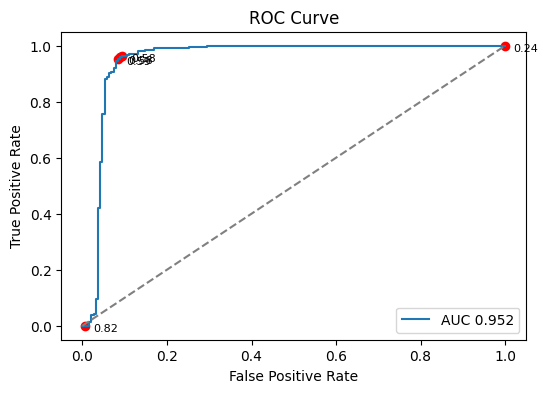

Best value near upper left corner!


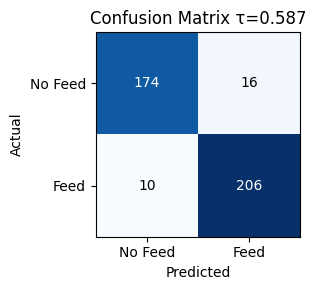

,Threshold,Accuracy,Precision,Recall,F1,Specificity,FPR
0,0.2410,0.532,0.532,1.000,0.695,0.000,1.000
1,0.5841,0.936,0.924,0.958,0.941,0.911,0.089
2,0.5867,0.936,0.928,0.954,0.941,0.916,0.084
3,0.5838,0.936,0.920,0.963,0.941,0.905,0.095
4,0.8228,0.466,0.000,0.000,0.000,0.995,0.005


False Positive Rate (FPR) - wrong feeding ratio   = FP / (FP + TN)
Specificity               - correct feeding ratio = TN / (TN + FP) = 1 − FPR


In [69]:
# Evaluate model

# 1. ROC CURVE
# Compute ROC curve and find best threshold
fpr, tpr, thresh = roc_curve(val_gt, val_preds)
roc_auc = auc(fpr, tpr)
best_idx = np.argmax(tpr - fpr)
best_th = thresh[best_idx]

# pick five thresholds: min, max, best, plus two next-best
valid = np.sort(np.unique(thresh[(thresh>0)&(thresh<1)]))
low, high = valid[0], valid[-1]
order = np.argsort(tpr - fpr)[::-1]
alts = [t for i,t in zip(order, thresh[order]) if t not in (low, high, best_th)][:2]
cands = [low, alts[0], best_th, alts[1], high]

# Plot ROC with markers
plt.figure(figsize=(6,4))
plt.plot(fpr, tpr, label=f"AUC {roc_auc:.3f}")
plt.plot([0,1],[0,1],'--', color='.5')
pts = [(fpr[np.where(thresh==t)[0][0]], tpr[np.where(thresh==t)[0][0]]) for t in cands]
xs, ys = zip(*pts)
plt.scatter(xs, ys, color='red')
for x,y,t in zip(xs, ys, cands):
    plt.text(x+0.02, y-0.02, f"{t:.2f}", fontsize=8)

plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
plt.legend(); plt.title("ROC Curve"); plt.show()

print("Best value near upper left corner!")

# 2. CONFUSION MATRIX
# Confusion matrix at best threshold
pred_best = (val_preds >= best_th).astype(int)
cm = confusion_matrix(val_gt, pred_best)
plt.figure(figsize=(4,3))
plt.imshow(cm, cmap="Blues"); plt.title(f"Confusion Matrix τ={best_th:.3f}")
plt.xticks([0,1],["No Feed","Feed"]); plt.yticks([0,1],["No Feed","Feed"])
for i in (0,1):
    for j in (0,1):
        plt.text(j, i, cm[i,j], ha='center', va='center',
                 color='white' if cm[i,j]>cm.max()/2 else 'black')
plt.xlabel("Predicted"); plt.ylabel("Actual"); plt.tight_layout(); plt.show()

# 3. METRICS TABLE
# Build metrics table for each candidate threshold
rows = []
for t in cands:
    pred = (val_preds >= t).astype(int)
    tn, fp, fn, tp = confusion_matrix(val_gt, pred).ravel()
    rows.append({
        "Threshold": t,
        "Accuracy": accuracy_score(val_gt, pred),
        "Precision": precision_score(val_gt, pred, zero_division=0),
        "Recall": recall_score(val_gt, pred),
        "F1": f1_score(val_gt, pred, zero_division=0),
        "Specificity": tn/(tn+fp) if tn+fp else 0,
        "FPR": fp/(fp+tn) if fp+tn else 0
    })
df = pd.DataFrame(rows)

# highlight the best-threshold row in light green
def highlight_best(row):
    return ["background-color: darkgreen" if row.Threshold==best_th else "" for _ in row]

display(
    df.style
      .format({"Threshold":"{:.4f}","Accuracy":"{:.3f}","Precision":"{:.3f}", "Recall":"{:.3f}","F1":"{:.3f}","Specificity":"{:.3f}","FPR":"{:.3f}"})
      .apply(highlight_best, axis=1)
)

# Quick definitions
print("False Positive Rate (FPR) - wrong feeding ratio   = FP / (FP + TN)\n"
      "Specificity               - correct feeding ratio = TN / (TN + FP) = 1 − FPR")
